## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    if y_train_true is not None:
        print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_pred, y_test_true))
    
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def balance_df(i_X_train, i_y_train, i_target_name):
    print(i_y_train.value_counts())

    df_for_balancing = pd.concat([i_X_train, i_y_train], axis=1)
    df_balanced = balance_df_by_target(df_for_balancing, i_target_name)

    print(df_balanced[i_target_name].value_counts())

    return df_balanced.drop(columns=i_target_name), df_balanced[i_target_name]

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


**Пути к директориям и файлам**

In [3]:
# input
TRAIN_PATH = 'course_project_train.csv'
TEST_PATH = 'course_project_test.csv'

# output
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.txt'

###  Обзор обучающего датасета

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


### Анализ целевой переменной

In [7]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
ALL_FEATURE_NAMES = BASE_FEATURE_NAMES + [TARGET_NAME]

In [8]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

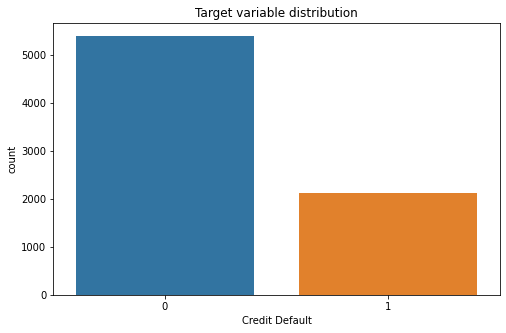

In [9]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train_df)

plt.title('Target variable distribution')
plt.show()

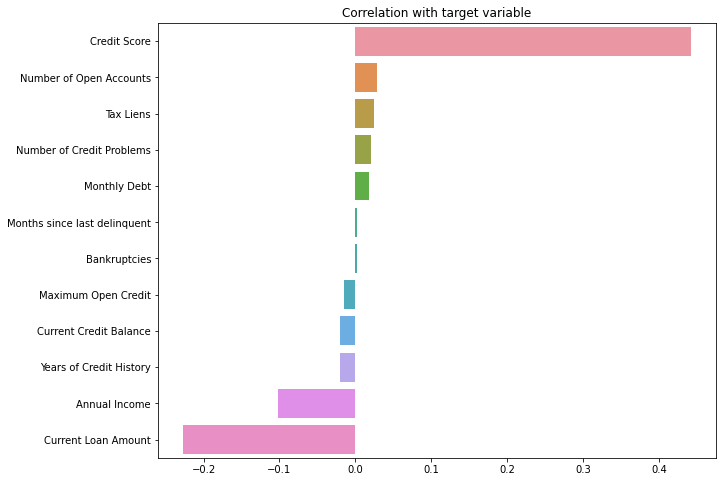

In [10]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

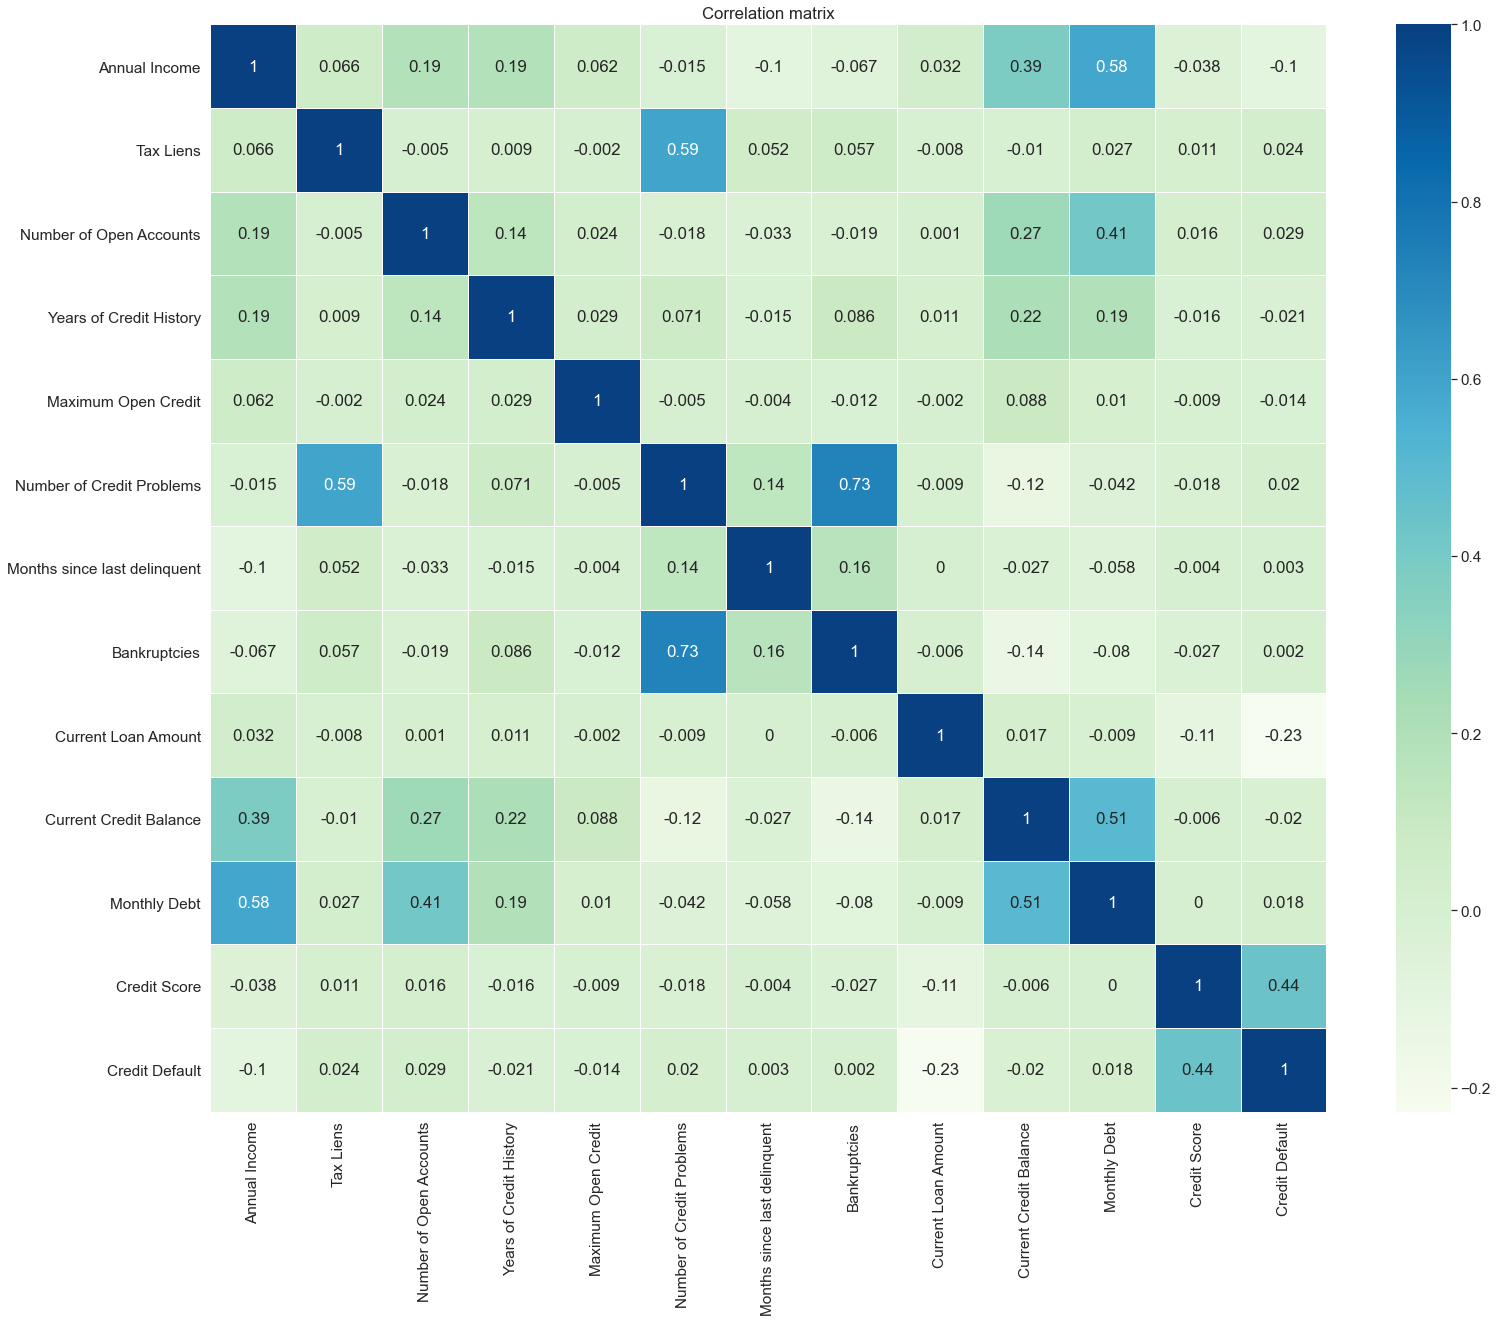

In [11]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.4)
sns.heatmap(train_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

### Обработка пропусков и построение новых признаков

In [12]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [13]:
def get_dict_vs(i_df):
    dict_cs = {
        'CS_1000': i_df[i_df['Credit Score'] >= 1000]['Credit Default'].mean(),
        'CS_0750': i_df[(i_df['Credit Score'] >= 750) & (i_df['Credit Score'] < 1000)]['Credit Default'].mean(),
        'CS_0740': i_df[(i_df['Credit Score'] >= 740) & (i_df['Credit Score'] < 750)]['Credit Default'].mean(),
        'CS_0730': i_df[(i_df['Credit Score'] >= 730) & (i_df['Credit Score'] < 740)]['Credit Default'].mean(),
        'CS_0720': i_df[(i_df['Credit Score'] >= 720) & (i_df['Credit Score'] < 730)]['Credit Default'].mean(),
        'CS_0710': i_df[(i_df['Credit Score'] >= 710) & (i_df['Credit Score'] < 720)]['Credit Default'].mean(),
        'CS_0700': i_df[(i_df['Credit Score'] >= 700) & (i_df['Credit Score'] < 710)]['Credit Default'].mean(),
        'CS_0690': i_df[(i_df['Credit Score'] >= 690) & (i_df['Credit Score'] < 700)]['Credit Default'].mean(),
        'CS_0680': i_df[(i_df['Credit Score'] >= 680) & (i_df['Credit Score'] < 690)]['Credit Default'].mean(),
        'CS_0670': i_df[(i_df['Credit Score'] >= 670) & (i_df['Credit Score'] < 680)]['Credit Default'].mean(),
        'CS_0660': i_df[(i_df['Credit Score'] >= 660) & (i_df['Credit Score'] < 670)]['Credit Default'].mean(),
        'CS_0650': i_df[(i_df['Credit Score'] >= 650) & (i_df['Credit Score'] < 660)]['Credit Default'].mean(),
        'CS_0640': i_df[(i_df['Credit Score'] >= 640) & (i_df['Credit Score'] < 650)]['Credit Default'].mean(),
        'CS_0630': i_df[(i_df['Credit Score'] >= 630) & (i_df['Credit Score'] < 640)]['Credit Default'].mean(),
        'CS_0620': i_df[(i_df['Credit Score'] >= 620) & (i_df['Credit Score'] < 630)]['Credit Default'].mean(),
        'CS_0610': i_df[(i_df['Credit Score'] >= 610) & (i_df['Credit Score'] < 620)]['Credit Default'].mean(),
        'CS_0600': i_df[(i_df['Credit Score'] >= 600) & (i_df['Credit Score'] < 610)]['Credit Default'].mean(),
        'CS_0500': i_df[(i_df['Credit Score'] >= 500) & (i_df['Credit Score'] < 600)]['Credit Default'].mean(),
        'CS_0001': i_df[(i_df['Credit Score'] >= 1) & (i_df['Credit Score'] < 0)]['Credit Default'].mean(),
        'CS_0000': i_df[i_df['Credit Score'] < 1]['Credit Default'].mean()
        }

    for key, value in dict_cs.items():
        if value is np.nan:
            dict_cs[key] = 0
            
    return dict_cs

In [14]:
def get_dicts(df):
    cat_fields = list(df.select_dtypes(include=['uint8']).columns)
    
    return (
        cat_fields,
        get_dict_vs(df), 
        df[~df['Credit Score'].isna()].groupby(['Credit Score']).\
            agg({'Credit Default':'mean'})['Credit Default'].sort_index(), 
        df.groupby(['Years in current job']).agg({'Annual Income':'median'})[ \
            'Annual Income'].to_dict(), 
        df.groupby(cat_fields, as_index=False).agg({'Credit Default':'mean'}).rename( \
            columns={'Credit Default':'Cat'})
    )

In [15]:
def prep_1(df, i_dict_ycj):
    df['Years in current job'] = df['Years in current job'].apply(lambda x: i_dict_ycj.get(x, -1)) #0)) # -1))
    df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1 #0 #-1
    df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = -1 #0 #-1
    df.loc[df['Credit Score'].isna(), 'Credit Score'] = -1
    df['Credit Score > 5000'] = ((df['Credit Score']>5000)*1).astype(np.uint8)
    df['Current Loan Amount 99999999'] = ((df['Current Loan Amount']==99999999)*1).astype(np.uint8)
    df = pd.get_dummies(df, drop_first=True)
    
    return df

In [16]:
def prep_2(df, i_dict_ai_med, i_dict_cs_m, i_dict_cat_m, i_cat_fields, dict_cs):
    test_fields = list(df.select_dtypes(include=['uint8']).columns)
    for f in [item for item in i_cat_fields if item not in test_fields]:
        df[f] = 0  
    df.loc[df['Annual Income'].isna(), 'Annual Income'] = df.loc[df['Annual Income'].isna(), \
        'Years in current job'].apply(lambda x: i_dict_ai_med.get(x))    
    df['Credit Score Default'] = df['Credit Score'].apply(lambda x: \
        i_dict_cs_m.iat[i_dict_cs_m.index.searchsorted(x, side='left')]) 
    df = df.merge(i_dict_cat_m, on=i_cat_fields, how='left')
    df = df.drop(columns=i_cat_fields)
    df.loc[df['Cat'].isna(), 'Cat'] = -1 
    df['CS'] = df['Credit Score'].apply(lambda x: dict_cs.get( \
        'CS_1000' if x >= 1000 else 
        'CS_0750' if (x >= 750) & (x < 1000) else 
        'CS_0740' if (x >= 740) & (x < 750) else 
        'CS_0730' if (x >= 730) & (x < 740) else 
        'CS_0720' if (x >= 720) & (x < 730) else 
        'CS_0710' if (x >= 710) & (x < 720) else 
        'CS_0700' if (x >= 700) & (x < 710) else 
        'CS_0690' if (x >= 690) & (x < 700) else 
        'CS_0680' if (x >= 680) & (x < 690) else 
        'CS_0670' if (x >= 670) & (x < 680) else 
        'CS_0660' if (x >= 660) & (x < 670) else 
        'CS_0650' if (x >= 650) & (x < 660) else 
        'CS_0640' if (x >= 640) & (x < 650) else 
        'CS_0630' if (x >= 630) & (x < 640) else 
        'CS_0620' if (x >= 620) & (x < 630) else 
        'CS_0610' if (x >= 610) & (x < 620) else 
        'CS_0600' if (x >= 600) & (x < 610) else 
        'CS_0500' if (x >= 500) & (x < 600) else 
        'CS_0001' if (x >= 1) & (x < 0) else 
        'CS_0000' ))  
    
    return df

In [17]:
df_copy = train_df.copy()
train_df, test_df = train_test_split(train_df, test_size=0.3, random_state=21, shuffle=True)
dict_ycj = { '< 1 year': 0, 
             '1 year': 1, 
             '2 years': 2, 
             '3 years': 3, 
             '4 years': 4,
             '5 years': 5, 
             '6 years': 6,
             '7 years': 7,
             '8 years': 8, 
             '9 years': 9,
             '10+ years': 10
           }

train_df = prep_1(train_df, dict_ycj)
cat_fields, dict_cs, dict_cs_m, dict_ai_med, dict_cat_m = get_dicts(train_df)
train_df = prep_2(train_df, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)
test_df = prep_1(test_df, dict_ycj)
test_df = prep_2(test_df, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)


## Обучение CatBoostClassifier

In [18]:
feature_names = train_df.columns.drop([TARGET_NAME]).tolist()
all_features = feature_names + [TARGET_NAME]
def call_CBC(i_X_train, i_y_train, i_X_test, i_y_test):
    cat_features = []
    params = {'n_estimators': [1000],
              'max_depth': [3]
             }
    cbc_model = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=cat_features, 
                                        class_weights=[1, 2.5]
                                       )
    gs = GridSearchCV(cbc_model, params, scoring='f1', cv=KFold(n_splits=3, random_state=21, shuffle=True), 
                      n_jobs=-1)
    gs.fit(i_X_train, i_y_train)

    print("best_score:", gs.best_score_)
    print("best_params:", gs.best_params_)

    y_train_pred = gs.best_estimator_.predict(i_X_train)
    y_test_pred = gs.best_estimator_.predict(i_X_test)

    get_classification_report(i_y_train, y_train_pred, i_y_test, y_test_pred)

    important_features_top = show_feature_importances(i_X_train.columns, gs.best_estimator_.feature_importances_, 
                                                      get_top=15)    
    
    return gs.best_estimator_, important_features_top

In [19]:
X_train = train_df[feature_names]
y_train = train_df[TARGET_NAME]
X_test = test_df[feature_names]
y_test = test_df[TARGET_NAME]

In [20]:
X_train_bal, y_train_bal = balance_df(X_train, y_train, TARGET_NAME)

0    3771
1    1479
Name: Credit Default, dtype: int64
0    3771
1    2958
Name: Credit Default, dtype: int64


best_score: 0.5619478124793572
best_params: {'max_depth': 3, 'n_estimators': 1000}
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3771
           1       0.59      0.76      0.66      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.78      0.75      5250
weighted avg       0.81      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1616
           1       0.48      0.61      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

Credit Default     0    1
row_0                    
0               1190  245
1                426  389


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


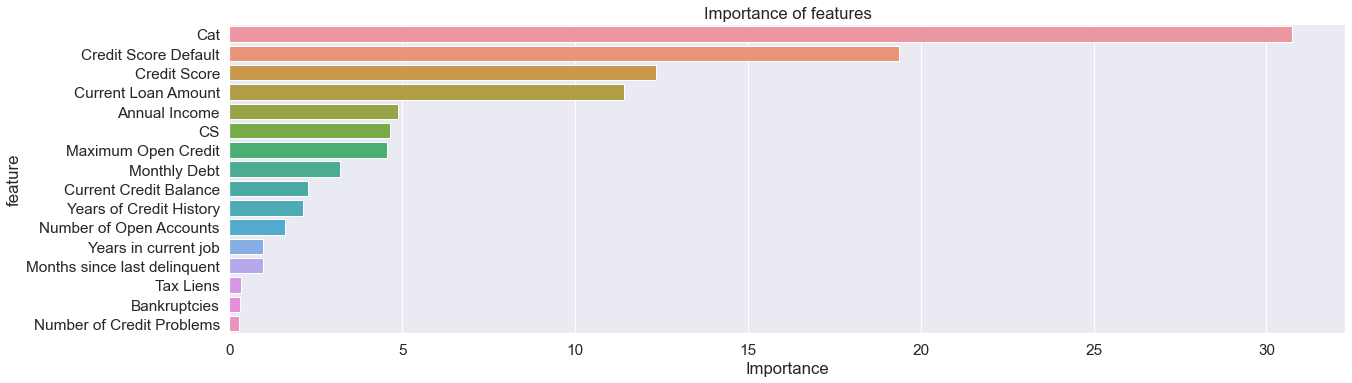

In [21]:
best_model, important_features_top = call_CBC(X_train, y_train, X_test, y_test)

In [22]:
X_train = train_df[important_features_top]
y_train = train_df[TARGET_NAME]
X_test = test_df[important_features_top]
y_test = test_df[TARGET_NAME]

best_score: 0.5631905626254688
best_params: {'max_depth': 3, 'n_estimators': 1000}
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3771
           1       0.59      0.76      0.66      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.77      0.75      5250
weighted avg       0.81      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1616
           1       0.47      0.62      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

Credit Default     0    1
row_0                    
0               1183  243
1                433  391


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


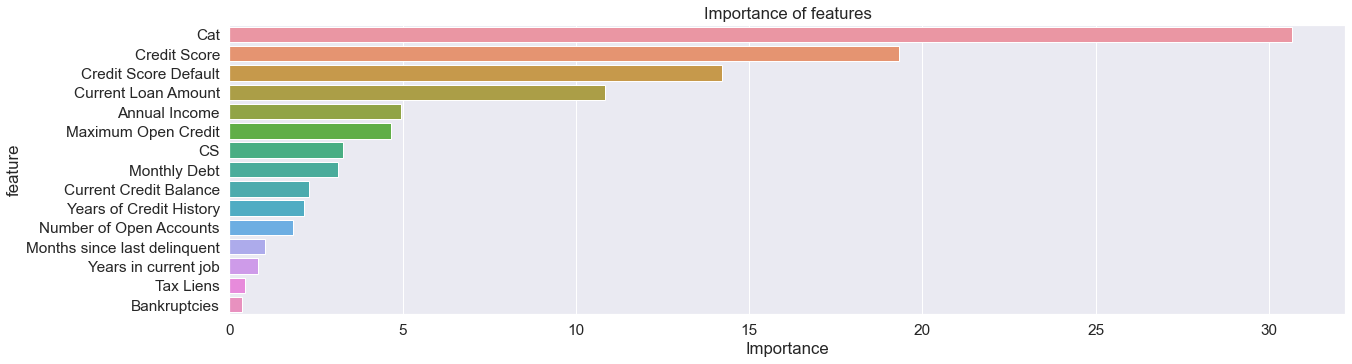

In [23]:
best_model, _ = call_CBC(X_train, y_train, X_test, y_test)

In [24]:
df_copy_test = df_copy.copy()
df_copy_test = prep_1(df_copy_test, dict_ycj)
df_copy_test = prep_2(df_copy_test, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

X_test = df_copy_test[important_features_top]
y_test = df_copy_test[TARGET_NAME]

get_classification_report(None, None, y_test, best_model.predict(X_test))

TEST

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      5387
           1       0.55      0.72      0.62      2113

    accuracy                           0.76      7500
   macro avg       0.71      0.74      0.72      7500
weighted avg       0.78      0.76      0.77      7500

CONFUSION MATRIX

Credit Default     0     1
row_0                     
0               4165   601
1               1222  1512


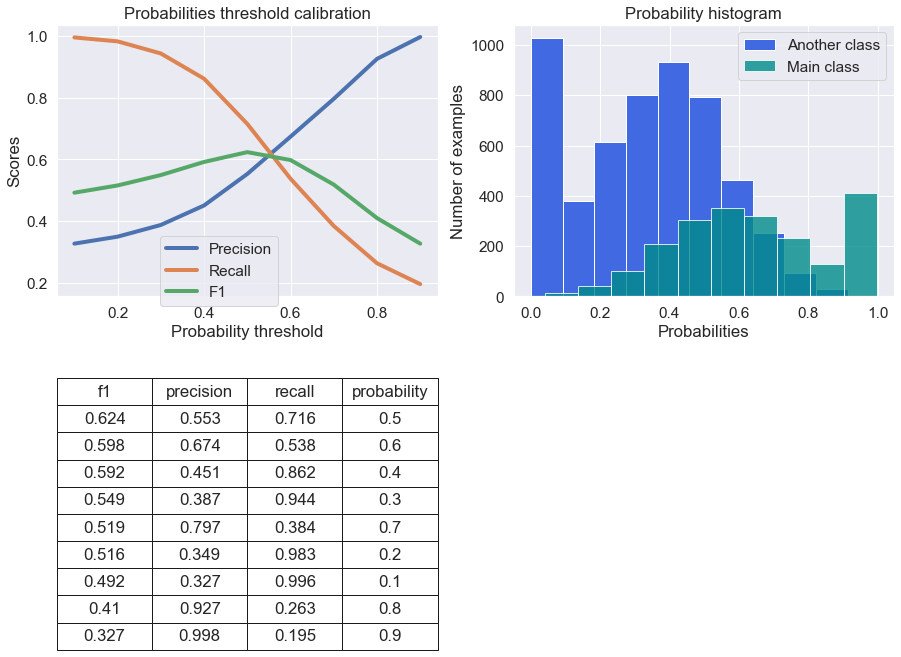

In [25]:
y_test_pred_probs = best_model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [26]:
df_copy = prep_1(df_copy, dict_ycj)
cat_fields, dict_cs, dict_cs_m, dict_ai_med, dict_cat_m = get_dicts(df_copy)
df_copy = prep_2(df_copy, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

X = df_copy[important_features_top]
y = df_copy[TARGET_NAME]

best_score: 0.5631905626254688
best_params: {'max_depth': 3, 'n_estimators': 1000}
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3771
           1       0.59      0.76      0.66      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.77      0.75      5250
weighted avg       0.81      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      5387
           1       0.57      0.72      0.63      2113

    accuracy                           0.77      7500
   macro avg       0.72      0.75      0.73      7500
weighted avg       0.79      0.77      0.77      7500

CONFUSION MATRIX

Credit Default     0     1
row_0                     
0               4227   602
1               1160  1511


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


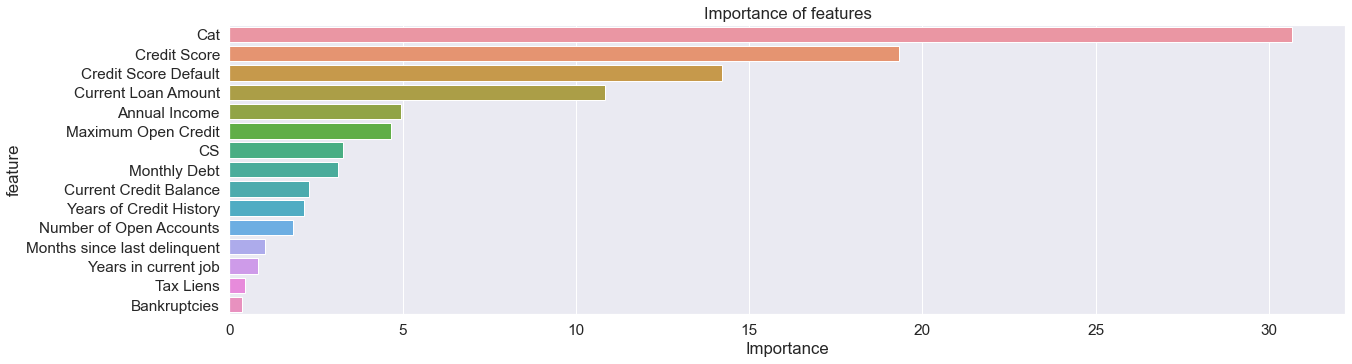

In [27]:
final_model, _ = call_CBC(X_train, y_train, X, y)

## Предскажем классы для тестовой выборки и запишем результаты в файл

In [28]:
df_test = pd.read_csv(TEST_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [29]:
df_test = prep_1(df_test, dict_ycj)
df_test = prep_2(df_test, dict_ai_med, dict_cs_m, dict_cat_m, cat_fields, dict_cs)

In [30]:
y_pred = final_model.predict(df_test[important_features_top])
result = pd.DataFrame({ 'Credit Default': y_pred })
result.head()

,Credit Default
0,0
1,1
2,1
3,0
4,0


In [31]:
result.to_csv('DVZheludkov_predictions.csv', sep=',', index=True, encoding='utf-8')